In [2]:
# magics: ensures that any changes to the modules loaded below will be re-loaded automatically
%load_ext autoreload
%autoreload 2

# load general packages
import numpy as np
import time
import copy

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
# load modules related to this exercise

# load general packages
import numpy as np
# load modules related to this exercise
from model_zucher import zurcher
from Solve_NFXP import solve_NFXP
import estimate_NFXP as estimate

# Exercise 2

#### 1. Ensure that you understand the code zucher.sim_data

#### 2. Illustrate the likelihood function for different values of RC and c

In [3]:
# Simulate the data

# Set up
model = zurcher()
solver = solve_NFXP()

# update starting value: 
N = 500
T = 119
ev,pk = solver.poly(model.bellman, beta = model.beta, output=2)

# data
data = zurcher.sim_data(model,N,T,pk) 
samplesize = data.shape[0]


In [4]:
# Find tha likelihood value for different combinations 

par_RC = copy.copy(model.RC)
par_c = copy.copy(model.c)

NRC = 30
Nc = 20

log_lik = np.nan + np.zeros((NRC,Nc))
RC= np.linspace(8,15,NRC)
c = np.linspace(1,4,Nc)

for i in range(NRC):
    for j in range(Nc):
       
        # STEP 1: Find p 
        tabulate = data.dx1.value_counts()
        p = [tabulate[i]/sum(tabulate) for i in range(tabulate.size-1)]

        # STEP 2: Estimate structual parameters
        model.p = p # Use first step estimates as starting values for t
    
        # Estimate RC and C
        pnames = ['RC','c']
        theta = np.array([RC[i], c[j]])
        log_lik[i,j]=estimate.ll(theta,model, solver,data, pnames)

log_lik *= samplesize*(-1)

#Re-inset the true parameters 
model.RC = copy.copy(par_RC)
model.c = copy.copy(par_c)

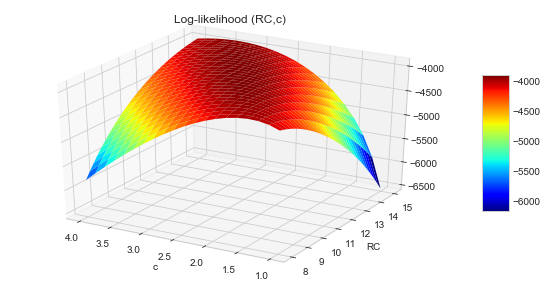

In [5]:
# plot figure in three dimensions
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
plt.style.use('seaborn-whitegrid')


fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1,projection='3d')

# Make data.
X, Y = np.meshgrid(c, RC)

# Plot the surface.
surf = ax.plot_surface(X, Y, log_lik, cmap=cm.jet)

# Customize the axis.
ax.set_xlabel(f'c')
ax.set_ylabel(f'RC')
ax.set_title(f'Log-likelihood (RC,c)')
ax.invert_xaxis()

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

#### 3. Estimate the model, do you get the correct estimates?

In [6]:
theta0 = [0,0]

# Estimate

nfxp_model, nfxp_results, pnames, theta_hat, Avar, converged=estimate.estimate(model, solver,data,theta0=theta0)



print(f'Log-Likelihood:     {-nfxp_results.fun*samplesize:.4f}')
print(f'RC:                 {theta_hat[0]:.4f}')
print(f'c:                  {theta_hat[1]:.4f}')


Log-Likelihood:     -63435.2804
RC:                 11.8371
c:                  2.5056


a) Try changing the starting values, does the model converges?

In [7]:
#starting values
rc_vec = np.array((0,12))
c_vec = np.array((0, 2, 40))

for i,rc in enumerate(rc_vec):
    for j, c in enumerate(c_vec):
        print(f'starting values: ({rc},{c})')
        t0 = time.time()
        
        # Update start values
        theta0 = [rc, c]
        
        # Estimate
        nfxp_model, nfxp_results, pnames, theta_hat, Avar, converged=estimate.estimate(model, solver,data,theta0=theta0)
        t1 = time.time()
        print(f'RC = {theta_hat[0]:.4f}, c = {theta_hat[1]:.4f}')
        print(f'The model converged: {converged}')
        print(f'Total time = {t1-t0:.4f} \n')
        

starting values: (0,0)
RC = 11.8371, c = 2.5056
The model converged: True
Total time = 1.9474 

starting values: (0,2)
RC = 11.8321, c = 2.5043
The model converged: True
Total time = 1.6807 

starting values: (0,40)
RC = 11.8371, c = 2.5056
The model converged: True
Total time = 2.5684 

starting values: (12,0)
RC = 11.8345, c = 2.5049
The model converged: True
Total time = 1.9984 

starting values: (12,2)
RC = 11.8371, c = 2.5056
The model converged: True
Total time = 1.2716 

starting values: (12,40)
RC = 11.8371, c = 2.5056
The model converged: True
Total time = 2.4463 



#### 4. What happen if you change the maximum number of Newton-Kantorovich iterations to 1? 
Do we get convergence? Do the estimates seem right? 


In [8]:
do_settings_solver = {
    'pi_max': 1,
    'pi_fxpiter': 1,  
    'printfxp': 1
}

solver = solve_NFXP(**do_settings_solver)
model = zurcher()
nfxp_model, nfxp_results, pnames, theta_hat, Avar, converged=estimate.estimate(model, solver,data,theta0=theta0)


Begin contraction iterations (for the 1 time)
Maximum number of iterations reached, tolerance: 6.9535
Elapsed time 0.0000 seconds
Begin Newton-Kantorovich iterations (for the 1 time)
Maximum number of iterations reached, tolerance: 43.0383
Elapsed time 0.0031 seconds
Begin contraction iterations (for the 2 time)
Maximum number of iterations reached, tolerance: 43.0383
Elapsed time 0.0000 seconds
Begin Newton-Kantorovich iterations (for the 2 time)
Maximum number of iterations reached, tolerance: 0.3625
Elapsed time 0.0023 seconds
Begin contraction iterations (for the 3 time)
Maximum number of iterations reached, tolerance: 0.3625
Elapsed time 0.0000 seconds
Begin Newton-Kantorovich iterations (for the 3 time)
Maximum number of iterations reached, tolerance: 0.0257
Elapsed time 0.0000 seconds
Begin contraction iterations (for the 4 time)
Maximum number of iterations reached, tolerance: 0.0257
Elapsed time 0.0000 seconds
Begin Newton-Kantorovich iterations (for the 4 time)
Maximum number

In [9]:
print(f'Log-Likelihood:     {-nfxp_results.fun*samplesize:.4f}')
print(f'RC:                 {theta_hat[0]:.4f}')
print(f'c:                  {theta_hat[1]:.4f}')


Log-Likelihood:     -63435.2804
RC:                 11.8372
c:                  2.5056
